# Lab Assignment Two: Exploring Image Data

Tela Sorrell, Kiswood Diogene, Martin Menard, and Emily Davidson

### Business Understanding

The data set that we selected features 75 different classes of butterflies, and it contains about 1000+ labelled images including validation images with each image belonging to only one butterfly class. The purpose of this data set is to predict what butterfly class the butterfly in the image belongs to, and the data was collected to strengthen butterfly classification in images. The data set has a butterfly category, which lists 75 categories of butterflies, and it will be used as the prediction task.

In our opinion, the third parties that would be interested in these results are lepidopterists societies or lepidopterists, who are entomologists who specialize in the study or collection of butterflies and moths, because this data will play a vital role in simplifying the identification and classification of butterflies in images for them. Lepidopterists examine the behavior and evolutionary history of various moth and butterfly species and document their activities, questions, ideas, problems, progress, and everything they have learned about butterfly specicies, so having this data can save time and minimize research necessary to classify butterfly species. They can utilize our prediction models to cross reference with the images they have taken themselves to get a strong conclusion about the class of butterfly they have captured.

According to research, our prediction algorithm would need to perform at about 88% accuracy to be considered useful to the identified third parties because current models that have been created to classify butterflies are performing at the lowest 84% and at the highest about 90%.

</br>

[Lepidoptery Source](https://www.ascd.org/el/articles/what-do-lepidopterists-do)
</br>
[Classification of Butterfly Species Using Pretrained Models Source](https://www.mdpi.com/2079-9292/11/13/2016)


### Data Preparation

[.5 points] Read in your images as numpy arrays. Resize and recolor images as necessary.
[.4 points] Linearize the images to create a table of 1-D image features (each row should be one image).   
[.1 points] Visualize several images.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

##### Imports

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn import preprocessing
import plotly.express as px
from sklearn.decomposition import KernelPCA, PCA
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from skimage.feature import daisy
from joblib import Parallel, delayed
import time
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances

##### Load in the Butterfly DataSet

In [3]:
def image_shrink(image, size=(100,100)):
    return cv2.resize(image, size)

In [4]:
# Read in images as numpy arrays
def load_images_from_folder(folder, size=(100, 100)):
    images = []
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        img = cv2.imread(file_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = image_shrink(img, size)
            images.append(img)
            print(f"Loaded image shape: {img.shape}")
        else:
            print(f"Failed to load image: {file_path}")
    return images

In [5]:
images = load_images_from_folder('Images')
print(f"Loaded {len(images)} images")

Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image shape: (100, 100, 3)
Loaded image s

In [6]:
# Linearize images to create table of 1-D image features (Turn into 1 row)
# Refrenced: https://stackoverflow.com/questions/36967920/numpy-flatten-rgb-image-array
def linearize_img(images):
    flattened = np.array([img.flatten() for img in images])
    print(flattened.shape)
    print(f"Flattened images shape: {flattened.shape}")
    return flattened

In [7]:
flat_images = linearize_img(images)
print(f"Flattened into single array of shape {flat_images.shape}")
print(flat_images)

(5400, 30000)
Flattened images shape: (5400, 30000)
Flattened into single array of shape (5400, 30000)
[[137 115  91 ... 133  74  40]
 [255 247 247 ... 109  70  34]
 [ 83  50  40 ... 106  91  88]
 ...
 [ 23  42  46 ... 255 255 255]
 [101 133 154 ... 191 189 190]
 [112 103  75 ... 136 124 100]]


In [8]:
def list_images(images,titles, num_row = 5,num_col=5):
    plt.figure(figsize=(3 * num_col, num_row *3))
    for i in range (num_row*num_col):
        if i < len(images):
            plt.subplot(num_row, num_col, i + 1)
            plt.imshow(images[i])
            plt.imshow(images[i])
            plt.title (titles[i], fontsize = 8)
            plt.axis('off')
    plt.tight_layout
    plt.show()

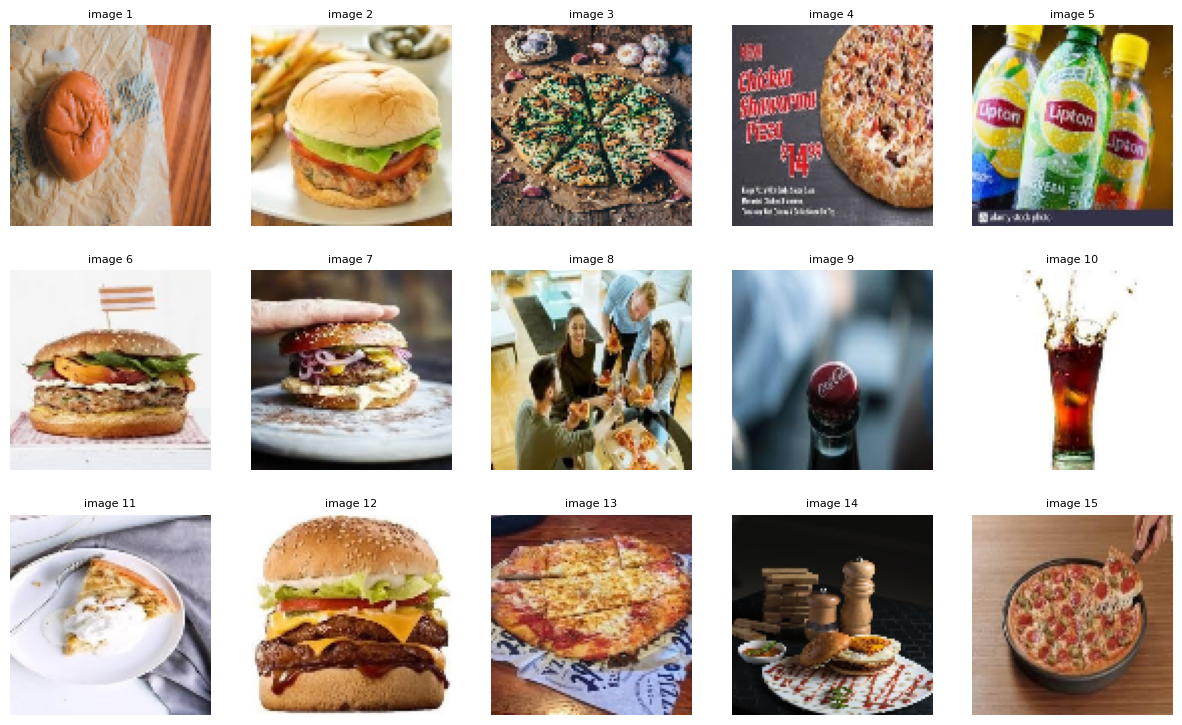

In [9]:
titles = [f'image {i+1}'for i in range(len(images))]
list_images(images[:25],titles[:25], num_row=3, num_col=5)

### Data Reduction

In [10]:
# Applying a Standard Scaler
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
# Referenced https://stackoverflow.com/questions/37221425/which-feature-scaling-method-to-use-before-pca
# Scales the data so every column (feature) can have a mean of 0 and a St.dev of 1
scaler = StandardScaler()
standard_image = scaler.fit_transform(flat_images)


In [11]:
labels_df = pd.read_csv('Training_set.csv')
print(labels_df.columns)
print(labels_df.head())

def get_category(row):
    if row['label'] == 'burgers':
        return 'Burgers'
    elif row['label'] == 'Softdrinks':
        return 'Softdrinks'
    elif row['label'] == 'Pizza':
        return 'Pizza'
    else:
        return 'Unknown'


labels_df['category'] = labels_df.apply(get_category, axis=1)

filename_to_category = dict(zip(labels_df['filename'], labels_df['category']))

class_labels = [filename_to_category[os.path.basename(filename)] for filename in os.listdir('Images') if filename != '.DS_Store']

print(class_labels)

Index(['filename', 'label'], dtype='object')
      filename    label
0  Image_1.jpg  burgers
1  Image_2.jpg  burgers
2  Image_3.jpg  burgers
3  Image_4.jpg  burgers
4  Image_5.jpg  burgers
['Burgers', 'Burgers', 'Pizza', 'Pizza', 'Softdrinks', 'Burgers', 'Burgers', 'Pizza', 'Softdrinks', 'Softdrinks', 'Pizza', 'Burgers', 'Pizza', 'Burgers', 'Pizza', 'Softdrinks', 'Pizza', 'Burgers', 'Pizza', 'Softdrinks', 'Burgers', 'Pizza', 'Softdrinks', 'Burgers', 'Pizza', 'Pizza', 'Softdrinks', 'Burgers', 'Pizza', 'Burgers', 'Pizza', 'Softdrinks', 'Burgers', 'Burgers', 'Pizza', 'Burgers', 'Pizza', 'Pizza', 'Softdrinks', 'Burgers', 'Burgers', 'Softdrinks', 'Softdrinks', 'Pizza', 'Softdrinks', 'Pizza', 'Burgers', 'Burgers', 'Burgers', 'Pizza', 'Softdrinks', 'Softdrinks', 'Burgers', 'Pizza', 'Burgers', 'Softdrinks', 'Softdrinks', 'Burgers', 'Softdrinks', 'Pizza', 'Softdrinks', 'Softdrinks', 'Pizza', 'Burgers', 'Pizza', 'Softdrinks', 'Burgers', 'Softdrinks', 'Softdrinks', 'Softdrinks', 'Burgers', 'Softd

In [12]:
num_of_components = 10
pca = PCA(n_components=num_of_components)
components = pca.fit_transform(standard_image)
print('pca:', components)

pca: [[ 11.24561368  32.99024557 -26.15696489 ... -19.89994144   9.83087155
   21.13521307]
 [-43.78289262  12.52679776 -43.5551727  ...   8.33139299 -33.2235358
  -22.01166273]
 [ 89.38245392  -8.35717234  11.95366103 ...  -1.8062503    9.32899415
    3.0524737 ]
 ...
 [ 98.19842653 -25.6995538   75.4647882  ... -24.47591555 -60.94242534
   -7.62679278]
 [ 24.42234304  16.12933646  35.94177429 ...  12.4337455  -11.66310768
  -24.39160574]
 [ 31.72003944 -21.96154401  10.45722068 ...   6.22556806   8.34703261
   -0.52502998]]


In [13]:
random_pca = PCA(n_components=10, svd_solver='randomized')
random_components = random_pca.fit_transform(standard_image)

In [14]:
titles = [f'image {i+1}' for i in range(len(images))]
df_pca = pd.DataFrame(components, columns=[f'PC{i+1}' for i in range(10)])
df_pca['title'] = titles
df_pca['class'] = class_labels
fig = px.scatter(df_pca, x='PC1', y='PC2', color='class', hover_name='title', title='Food Items Avialble')
fig.show()

**PCA Analysis: The graph above displays the data spread across the first two principal components. The overlapping of classes indicates that using only two components is not sufficient to achieve a clear separation between the classes. To address this, we will use a dimensionality reduction technique such as t-SNE, which may provide better separation and visualization of the classes.**

In [15]:
# Reference https://stats.stackexchange.com/questions/584174/interpretation-of-low-variance-in-pca
# Reference https://stackoverflow.com/questions/32857029/python-scikit-learn-pca-explained-variance-ratio-cutoff
# Reference https://stackoverflow.com/questions/74296474/how-to-interpret-explained-variance-ratio-plot-from-principal-components-of-pca
# Refence   https://stackoverflow.com/questions/57293716/sklearn-pca-explained-variance-and-explained-variance-ratio-difference

explain_var_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explain_var_ratio)

fig = px.bar(
    x=[f'PC {i+1}' for i in range(len(explain_var_ratio))],
    y=explain_var_ratio,
    labels={'x': 'Principal Component', 'y': 'Explained Variance Ratio'},
    title='Explained Variance Ratio of Principal Components'
)
fig.show()

**We use this to understand the explained variance to understand how much variance each component has to determine how many components to consider**


In [16]:
df_random_pca = pd.DataFrame(random_components, columns=[f'PC{i+1}' for i in range(10)])
df_random_pca['title'] = titles
df_random_pca['class'] = class_labels
fig = px.scatter(df_random_pca, x='PC1', y='PC2', color='class', hover_name='title', title='Randomized PCA of Meat Freshness')
fig.show()

**Shows data points are spreaded but classes are not seperated which means that we may need more components. We will check how much variance each component has and if it doesn't capture much variance we will likely need to add more**

In [17]:
fig = px.scatter(df_pca, x='PC1', y='PC2', color='class', hover_name='title', title='PCA of Meat-Freshness')
fig.show()

#### Reference: https://medium.com/@abhishek8694/linear-vs-non-linear-dimensionality-reduction-pca-and-kernel-pca-10490f345ba9#:~:text=However%2C%20PCA%20has%20limitations%20when,underlying%20structure%20of%20the%20data.
**We standardized the data using standard scaler to help the PCA. We showing 10 principal components which didn't really improve class seperation (Which could be due to our complex data set of butterfly images which are high dimensional and have non-linear patterns that PCA may not capture well)**

In [18]:
# Reference: https://ml-lectures.org/docs/structuring_data/ml_without_neural_network-3.html
# Reference: https://www.datacamp.com/tutorial/introduction-t-sne
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, learning_rate=200)
tsne_components = tsne.fit_transform(standard_image)

df_tsne = pd.DataFrame(tsne_components, columns=['TSNE1', 'TSNE2'])
df_tsne['title'] = [f'image {i+1}' for i in range(len(images))]
df_tsne['class'] = class_labels

We used T-SNE, an unsupervised non-linear dimensionality reduction technique for data exploration and visualizing high-dimensional data. Non-linear dimensionality reduction means that the algorithm allows us to separate data that cannot be separated by a straight line. T-SNE allows for a non-linear dimensionality reduction technique to capture complex patterns in the data.

Each butterfly has many different feautures using T-SNE we can understand how these butterflies group together based on these features

t-SNE helps reduce complexity by taking all features and compresses them into just 2 or 3 values while trying to keep butterflies that are similar close to each other.


In [19]:
fig = px.scatter(df_tsne, x='TSNE1', y='TSNE2', color='class', hover_name='title', title='t-SNE of Butterfly Data')
fig.show()

### Feature Extraction

In [64]:
def daisy_viz(image, step=35, radius=10, rings=2, histograms=6, orientations=8):
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Extract DAISY features with visualization
    feat, img_desc = daisy(gray_image, step=step, radius=radius, rings=rings, histograms=histograms, orientations=orientations, visualize=True)
    return feat, img_desc

In [65]:
image = images[0]
features, img_desc = daisy_viz(image, step=35, radius=10, rings=2, histograms=6, orientations=8)

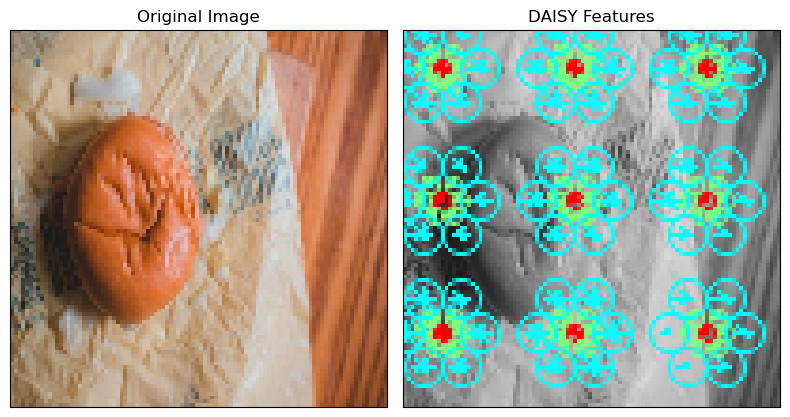

(3, 3, 104)


In [66]:
plt.figure(figsize=(8, 6))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Original Image', size=12)
plt.xticks(())
plt.yticks(())
plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(img_desc, cmap=plt.cm.gray)
plt.title('DAISY Features', size=12)
plt.xticks(())
plt.yticks(())
plt.grid(False)

plt.tight_layout()
plt.show()

print(features.shape)


In [67]:
def daisy_features(img_row, img_size):
    gray_img = cv2.cvtColor(img_row.reshape(img_size, img_size, 3), cv2.COLOR_RGB2GRAY)
    daisy_feats = daisy(
        gray_img,
        step=10,
        radius=10,
        rings=2,
        histograms=6,
        orientations=8,
        visualize=False
    )
    return daisy_feats.reshape((-1))

In [68]:
img_size = 100
%time daisy_feats_all_imgs = [daisy_features(flat_images[i], img_size) for i in range(len(flat_images))]

CPU times: user 28 s, sys: 1.08 s, total: 29.1 s
Wall time: 29.7 s


**We have done feature extraction using the DAISY descriptor and visualizes the DAISY features for a sample image within our data set. Feature extraction allowed us transform raw image data into measurable features that we can use for ML (i.e.,such as classification or regression) These features help capture important characteristics and patterns within the images which helps highlight the differences between different classes. We will visualize the difference between statistics of extracted features because Visualizing the mean and variance of extracted features across different classes helps us understand how these features are distributed.**

In [70]:
def get_daisy_statistics(daisy_features):
    means = []
    variances = []
    for features in daisy_features:
        means.append(np.mean(features))
        variances.append(np.var(features))
    return np.array(means), np.array(variances)

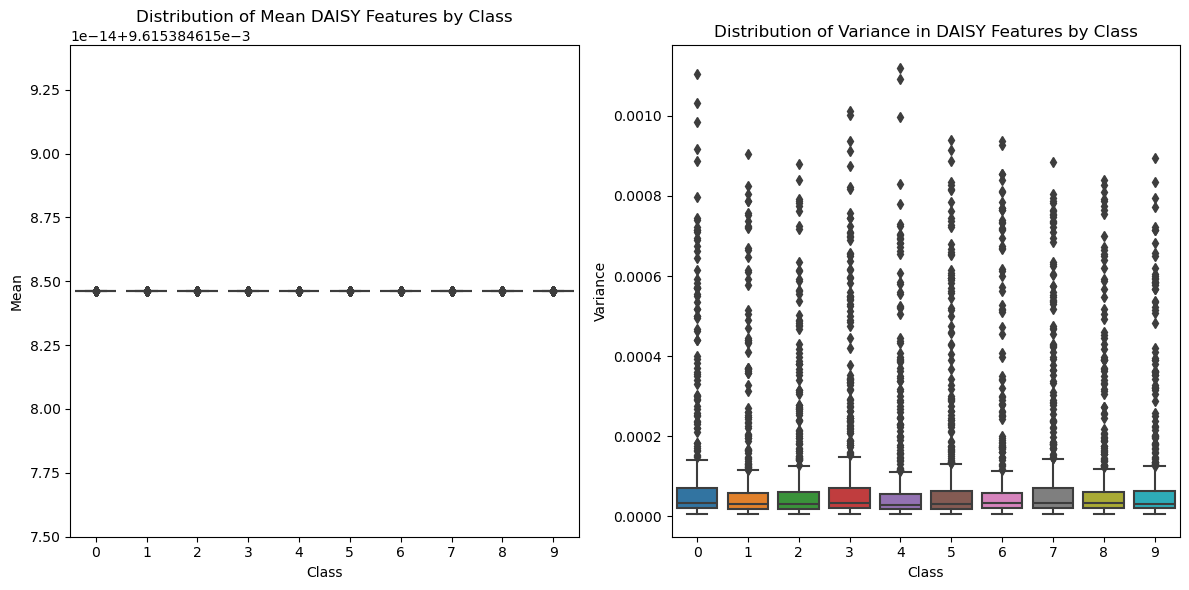

In [71]:
# Reference: https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_daisy.html
# Refernce: https://www.datacamp.com/community/tutorials/image-processing-python
# Reference: https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.daisy

num_classes = 10  
class_labels = np.random.randint(0, num_classes, len(flat_images))

#Statistics of the DAISY features
means, variances = get_daisy_statistics(daisy_feats_all_imgs)

# Creating DF
df_stats = pd.DataFrame({
    'Class': class_labels,
    'Mean': means,
    'Variance': variances
})

# We are creating the actual visuals
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='Class', y='Mean', data=df_stats)
plt.title('Distribution of Mean DAISY Features by Class')

plt.subplot(1, 2, 2)
sns.boxplot(x='Class', y='Variance', data=df_stats)
plt.title('Distribution of Variance in DAISY Features by Class')

plt.tight_layout()
plt.show()

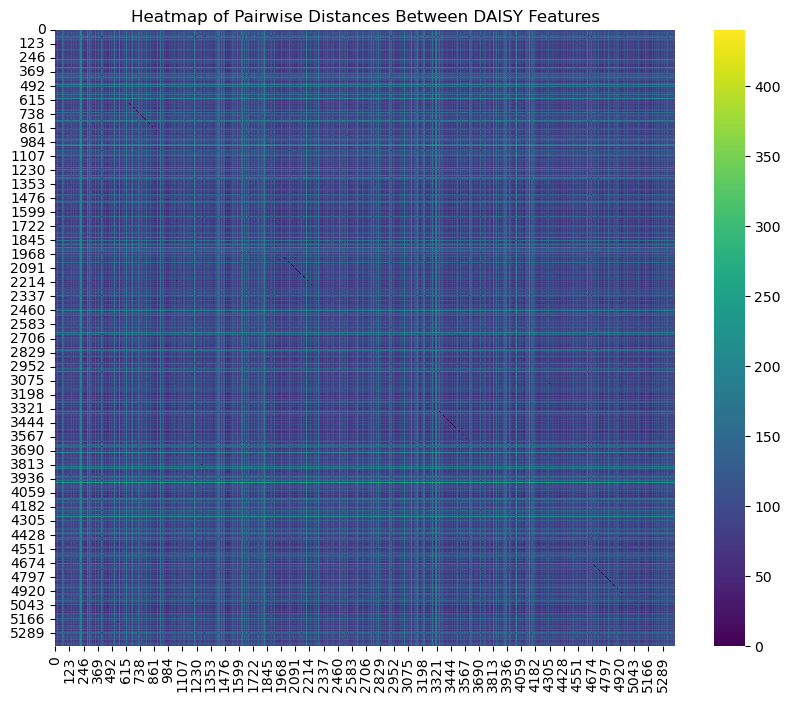

In [75]:
# Reference: https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_daisy.html
# Reference: https://www.datacamp.com/community/tutorials/image-processing-python
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html
# Reference: https://seaborn.pydata.org/generated/seaborn.heatmap.htmlnormalized_features = scaler.fit_transform(daisy_feats_all_imgs)

pairwise_dists = pairwise_distances(normalized_features)

plt.figure(figsize=(10, 8))
sns.heatmap(pairwise_dists, cmap='viridis')
plt.title('Heatmap of Pairwise Distances Between DAISY Features')
plt.show()

### Does this feature extraction method show promise for your prediction task? Why?

The DAISY feature extraction method shows promise for our prediction task. The boxplots of the mean and variance of DAISY features across different classes indicate that there are differences in the distributions. This means that DAISY was able to identify unique characteristics of each class, which helps with the ability to distinguish between them.

### Heatmap of Pairwise Distances:

The heatmap shows the pairwise distances between the DAISY features of all images. We notice patterns and clusters and this suggests that similar images have similar feature vectors. This clustering is a good sign because it implies that the DAISY features can effectively capture similarities and differences between images.

Based on distributions of these features, we can see that they vary across classes. This variability is what we need for our classifications to be accurate. The heatmap shows how images group together based on their features, which is what we want when trying to classify different images.